In [2]:
#%%
# Import required modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.independent import Independent
from lightning_data_modules.SyntheticDataset import SyntheticDataModule
from configs.jan.GaussianBubbles import get_config
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
from lightning_modules.FokkerPlanckModel import FokkerPlanckModel
from lightning_modules.ConservativeSdeGenerativeModel import ConservativeSdeGenerativeModel
from models.fcn_potential import FCN_Potential
from models.fcn import FCN
from models.utils import get_score_fn
from utils import compute_divergence, compute_grad, compute_curl, generate_grid, extract_vector_field, fisher_divergence
from plot_utils import plot_log_energy

In [3]:
def eval_model(ckpt_path, config):
    data_m = SyntheticDataModule(config)
    data_m.setup()

    d=4
    n=25
    dx = 2*d/n
    c=[0,0]
    x = np.linspace(-d + c[0], d + c[0], n)
    y = np.linspace(-d + c[1], d + c[1], n)
    # Meshgrid
    X,Y = np.meshgrid(x,y)
    XYpairs = np.stack([ X.reshape(-1), Y.reshape(-1) ], axis=1)
    XYpairs_tensor = torch.from_numpy(XYpairs) + 1e-10 # for numerical stability
    XYpairs_tensor=XYpairs_tensor.float()


    model = FokkerPlanckModel.load_from_checkpoint(ckpt_path)
    score_model = model.score_model
    model.configure_sde(config)
    model = model.eval()

    t=0.01
    vector_X, vector_Y = extract_vector_field(model, X, Y, t)
    plt.figure(figsize=(10, 10))
    plt.quiver(X,Y,vector_X,vector_Y)
    plt.grid()
    plt.title('Model at t =' +str(t))
    plt.show()

    try:
        log_energy = plot_log_energy(score_model, t, X, Y)
    except:
        print('Vanilla model, no energy plot')


    t_tensor = torch.tensor([t]*len(XYpairs_tensor))
    s_x = lambda w: score_model(w , t_tensor)
    curl = compute_curl(s_x, XYpairs_tensor).abs().mean().item()
    print('Curl =', curl)


    fd_0 = fisher_divergence(model, data_m, t=0)
    fd_1 = fisher_divergence(model, data_m, t=0.99)
    fd = fisher_divergence(model, data_m, grid=False)

    print('avreage fisher divergence = ', fd)
    print('t=0 fisher divergence = ', fd_0)
    print('t=1 fisher divergence = ', fd_1)

# Fokker Planck Model

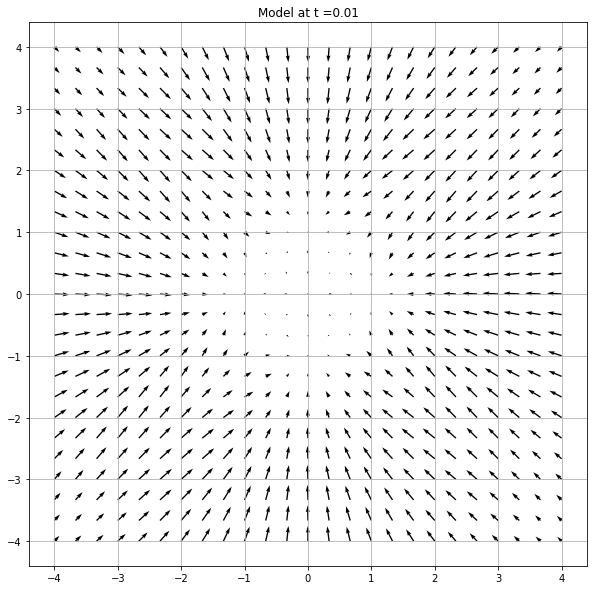

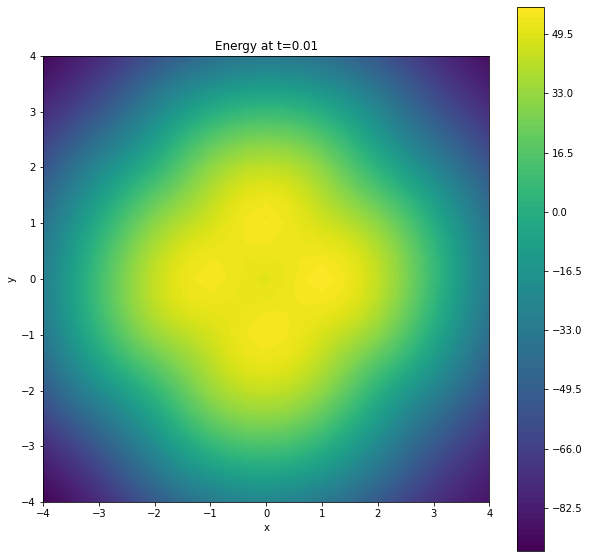

Curl = 3.712975967573584e-06
avreage fisher divergence =  0.2592712342739105
t=0 fisher divergence =  40.62672424316406
t=1 fisher divergence =  0.0010664091678336263


In [66]:
from configs.jan.gaussian.fokker_planck_gauss import get_config
config = get_config()
#ckpt_path = 'logs/gaussian_bubbles/fokker_planck/fp_v5_alpha_from_0_0001_to_1/checkpoints/best/last.ckpt'
ckpt_path = "logs/gaussian_bubbles/fokker_planck/fp_grad-alpha_0_0001_to_0_01_deep/checkpoints/best/last.ckpt"
eval_model(ckpt_path, config)

# Potential Model

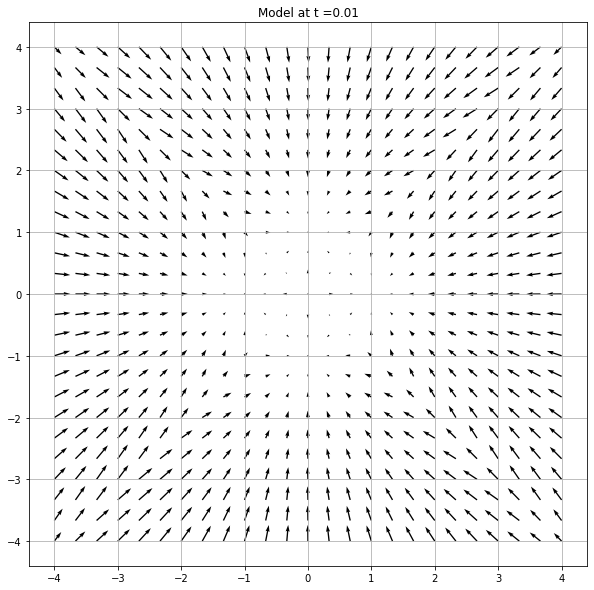

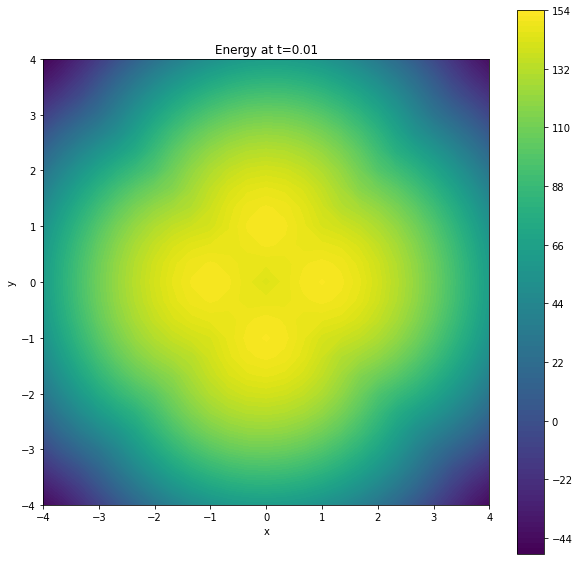

Curl = 2.407974079687847e-06
avreage fisher divergence =  0.005182674620300531
t=0 fisher divergence =  18.592605590820312
t=1 fisher divergence =  3.691249366966076e-05


In [64]:
from configs.jan.gaussian.fokker_planck_gauss import get_config
config = get_config()
ckpt_path = 'logs/gaussian_bubbles/fokker_planck/fp_grad-alpha_0/checkpoints/best/last.ckpt'
eval_model(ckpt_path, config)

# Vanilla Model

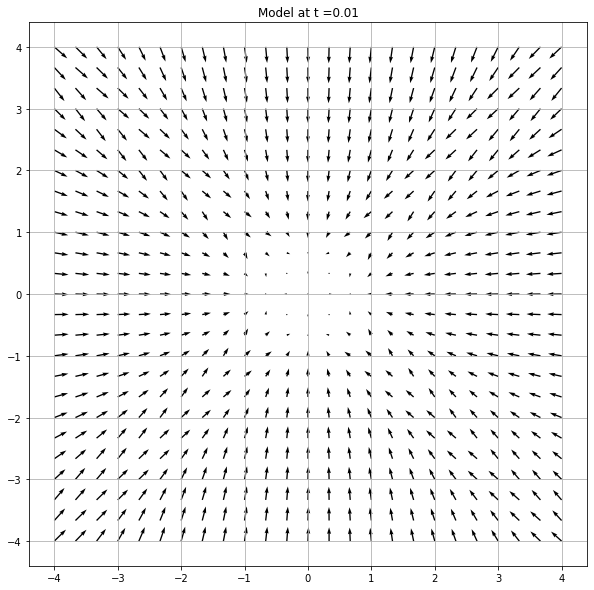

Vanilla model, no energy plot
Curl = 0.1690865308046341
avreage fisher divergence =  115.63372802734375
t=0 fisher divergence =  579.270751953125
t=1 fisher divergence =  2.4214401245117188


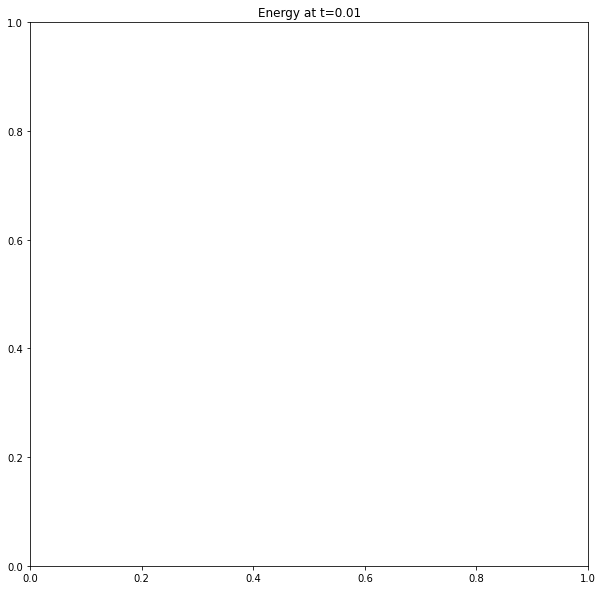

In [61]:
from configs.jan.gaussian.vesde import get_config
config = get_config()
ckpt_path = 'logs/gaussian_bubbles/lightning_logs/version_1/checkpoints/epoch=6249-step=499999.ckpt'
eval_model(ckpt_path, config)

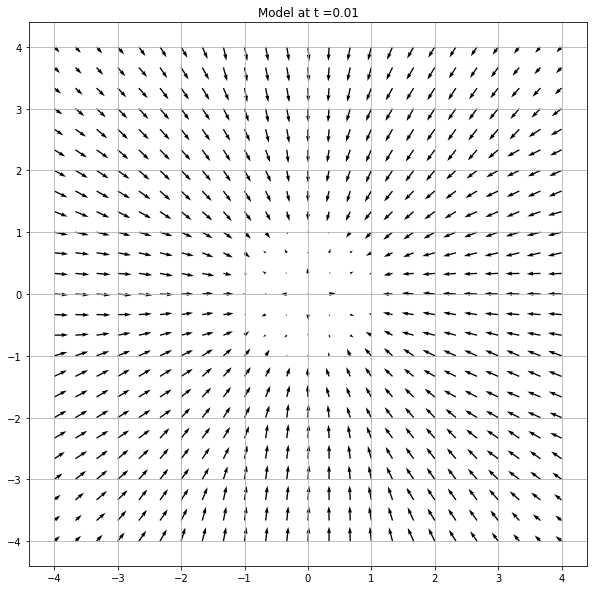

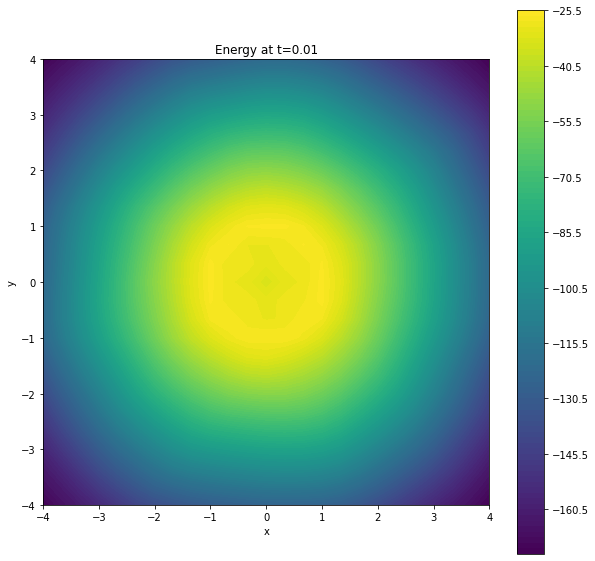

Curl = 1.3154506177670555e-06


TypeError: exceptions must derive from BaseException

In [8]:
from configs.jan.circles.fokker_planck.fokker_planck_circles import get_config 
config = get_config()
ckpt_path = 'logs/circles/fokker_planck/fp_ve_alpha_0/checkpoints/epoch=13317-step=1065439.ckpt'
#ckpt_path = 'logs/circles/fokker_planck/fp_grad-alpha_0_0001_to_0_01_deep/checkpoints/best/last.ckpt'
eval_model(ckpt_path, config)